## Notebook showing a hybrid stacker bagger
### For training:
##### Validation scores
1) Each base learner is trained on a subset of the items, split by some category
2) Each base learner is then made to predict on the whole validation set to get validation score
3) these validation scores used to train metamodel

##### Retraining
1) Each learner retrained on the whole subset of their items

### For testing:
1) Each learner predicts on whole training set, predictions are then passed to metamodel which makes final predictions.

In [1]:
from PrepareData import prepare_data
from lightgbm.sklearn import LGBMRanker
from sklearn.ensemble import AdaBoostClassifier
from rankers.Stacker import Stacker
from rankers.Ranker import Ranker
import numpy as np
from Evaluations import get_evaluation_plots


In [2]:
#10 weeks in total for training, validation is done on last 5 weeks, 3 base rankers used
nr_training_weeks = 10
nr_validation_weeks = 5
nr_rankers = 3

In [3]:
train, test, train_baskets, bestsellers_previous_week, test_week_transactions = prepare_data(kaggle_submission=False, nr_training_weeks=nr_training_weeks)

/home/peter/data_science/Year2/AI Project/Project/ai-project-23-24/PeterKirby/PrepareData.py:112: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  transactions['purchased'] = 1                                   #this cell produces a warning, but can be ignored as we use "transactions" slice to produce the returned dataframe


In [4]:
columns_to_use = ['article_id', 'product_type_no', 'graphical_appearance_no', 'colour_group_code', 'perceived_colour_value_id',
'perceived_colour_master_id', 'department_no', 'index_code',
'index_group_no', 'section_no', 'garment_group_no', 'FN', 'Active',
'club_member_status', 'fashion_news_frequency', 'age', 'postal_code', 'bestseller_rank']

In [5]:
test_X = test

In [6]:
#list of base rankers - all LGBM for speed
base_rankers = [LGBMRanker(
    objective="lambdarank",
    metric="ndcg",
    boosting_type="dart",
    n_estimators=1,
    importance_type='gain',
    verbose=0
) for i in range(nr_rankers)]

In [7]:
#first test just using garment_group_no for split
stacker = Stacker(base_rankers, Ranker(AdaBoostClassifier()), use_groups=[True for i in range(nr_rankers)], split_category="garment_group_no")

In [8]:
stacker.fit(train, columns_to_use, nr_validation_weeks=nr_validation_weeks)

Category 'garment_group_no' splits: [array([1009, 1013, 1007, 1001, 1021, 1003, 1016], dtype=int32), array([1006, 1025, 1017, 1012, 1020, 1008, 1023], dtype=int32), array([1014, 1018, 1019, 1002, 1010, 1011, 1005], dtype=int32)]
computing validation predictions for each of the base rankers...
training metamodel


/home/peter/data_science/Year2/AI Project/Project/ai-project-23-24/PeterKirby/rankers/Stacker.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_no_val[f"train{i}"] = train.groupby(['week', 'customer_id'])[f"ranker{i}"].rank(ascending=False)              #ascending so "best rank" is always the same number (1) - same done when predicting
/home/peter/data_science/Year2/AI Project/Project/ai-project-23-24/PeterKirby/rankers/Stacker.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_no_val[f"tra

metamodel training shape: (5124830, 3)
Computing scores on validatation...
retraining base rankers on full training set...


In [9]:
#getting predictions from garment_group_split-trained metamodel, include sanity check of intermediate predicton matrix sixe (predictions from base rankers) and contents
test['stacker_bagger'] = stacker.predict(test_X, columns_to_use, weighting="metamodel")

Predicting with metamodel
Prediction matrix shape: (6658206, 3)
prediction matrix:
[[ 1.   1.   1. ]
 [ 9.5  7.5  7.5]
 [ 9.5  7.5  7.5]
 ...
 [ 7.5  7.5  7.5]
 [12.   7.5  7.5]
 [12.   7.5  7.5]]


In [10]:
test['unweighted'] = stacker.predict(test_X, columns_to_use, weighting=None)

Predicting with None weighting


In [11]:
test['MRR_weighted'] = stacker.predict(test_X, columns_to_use, weighting="MRR")

Predicting with MRR weighting


In [12]:
test['MAPk_weighted'] = stacker.predict(test_X, columns_to_use, weighting="MAPk")

Predicting with MAPk weighting


In [13]:
for i in range(len(base_rankers)):
    test[f'ranker{i}'] = base_rankers[i].predict(test_X[columns_to_use])

In [14]:
#names of columns that are ranking predictions (ranker{i} columns are the predictions of the base rankers)
pred_cols =['stacker_bagger', 'unweighted', 'MRR_weighted', 'MAPk_weighted'] + [f"ranker{i}" for i in range(len(base_rankers))]

In [15]:
#sanity check - checking predicitons arent all exactly the same value
len(np.unique(test['stacker_bagger']))

335

In [17]:
len(np.unique(test['ranker2']))

31

In [18]:
#sanity check to see if rankings are given
test['stacker_bagger']

11557594    6551989.5
11557595    2272252.0
11557596    2272252.0
11557597    5158901.0
11557598    5158901.0
              ...    
18215795    4094008.0
18215796     980042.5
18215797    4094008.0
18215798     980042.5
18215799     980042.5
Name: stacker_bagger, Length: 6658206, dtype: float64

In [19]:
#sanity check for test dataset head
test.head()

,t_dat,customer_id,article_id,price,sales_channel_id,week,purchased,bestseller_rank,product_code,prod_name,...,fashion_news_frequency,age,postal_code,ranker0,ranker1,ranker2,stacker_bagger,unweighted,MRR_weighted,MAPk_weighted
11557594,2020-09-03,28847241659200,925246001,0.128797,2,104,0.0,999.0,925246,25454,...,1,21,57896,0.191023,0.160823,0.142614,6551989.5,6637206.5,6637206.5,6637206.5
11557595,2020-07-14,28847241659200,909370001,0.032947,1,104,0.0,1.0,909370,23319,...,1,21,57896,-0.187008,-0.198810,-0.197414,2272252.0,1944833.5,1944833.5,1944833.5
11557596,2020-07-14,28847241659200,865799006,0.033340,1,104,0.0,2.0,865799,18468,...,1,21,57896,-0.187008,-0.198810,-0.197414,2272252.0,1944833.5,1944833.5,1944833.5
11557597,2020-07-14,28847241659200,918522001,0.041416,1,104,0.0,3.0,918522,26372,...,1,21,57896,-0.123589,-0.198810,-0.197414,5158901.0,5199210.5,5199210.5,5199210.5
11557598,2020-07-14,28847241659200,924243001,0.041549,1,104,0.0,4.0,924243,19190,...,1,21,57896,-0.123589,-0.198810,-0.197414,5158901.0,5199210.5,5199210.5,5199210.5


Evaluation for stacker_bagger
####################

MAP@12 (all customers):             0.0011616401200390879
MAP@12 (only purchasing customers): 0.02310314003089451

MRR (all customers):                0.002190062909679821
MRR (only purchasing customers):    0.043556803183673325



Evaluation for unweighted
####################

MAP@12 (all customers):             0.0011641742999792947
MAP@12 (only purchasing customers): 0.023153540764316267

MRR (all customers):                0.002189798259146944
MRR (only purchasing customers):    0.04355153971333098



Evaluation for MRR_weighted
####################

MAP@12 (all customers):             0.0011643413676947231
MAP@12 (only purchasing customers): 0.023156863470512098

MRR (all customers):                0.0021903084706660627
MRR (only purchasing customers):    0.0435616869938598



Evaluation for MAPk_weighted
####################

MAP@12 (all customers):             0.0011643190983099269
MAP@12 (only purchasing customers): 0.0231564

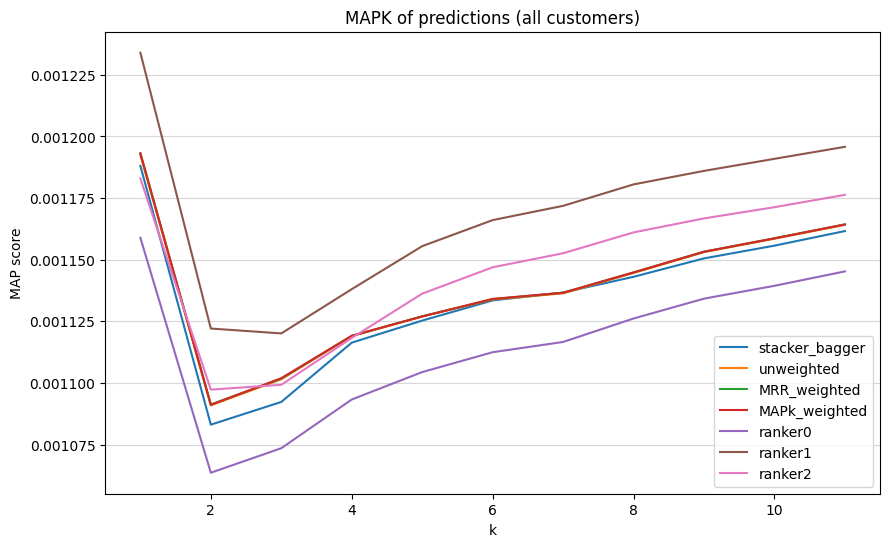

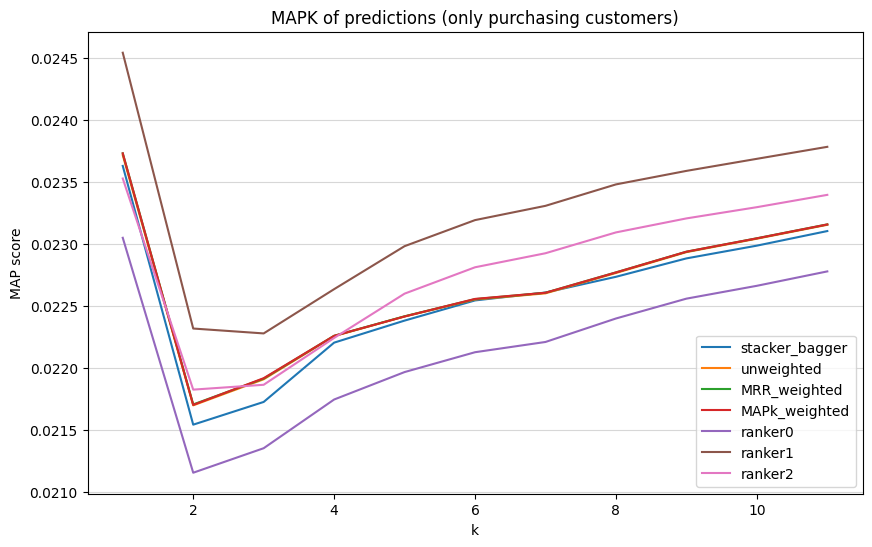

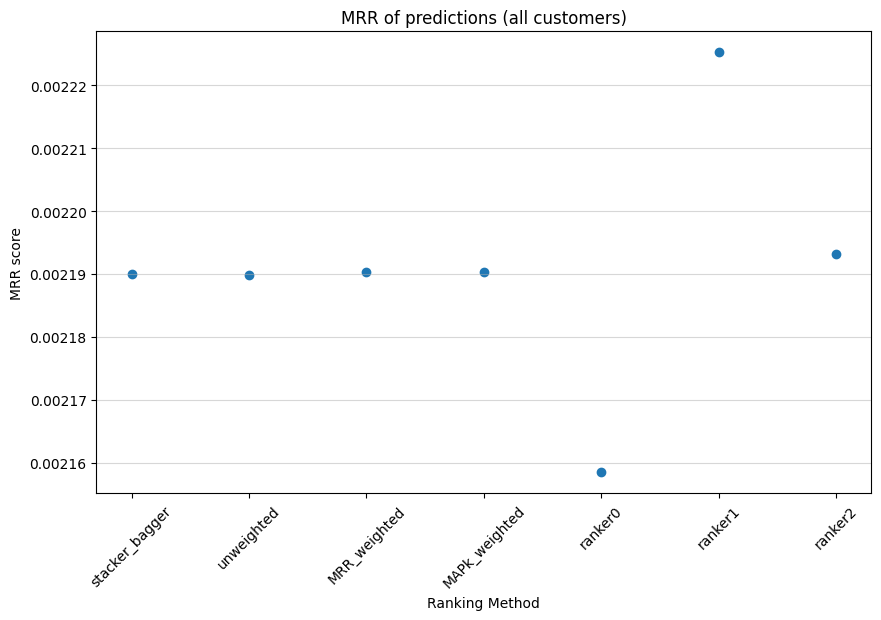

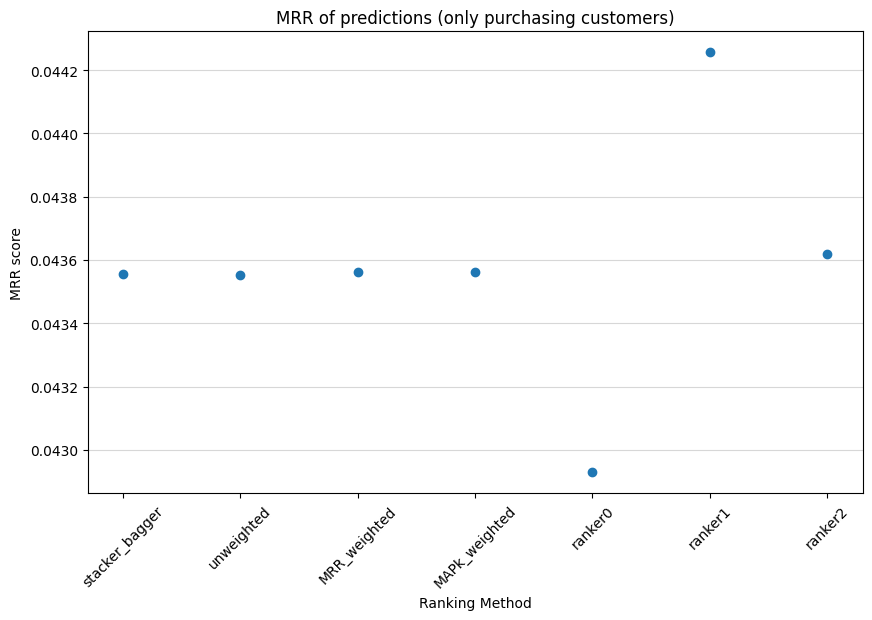

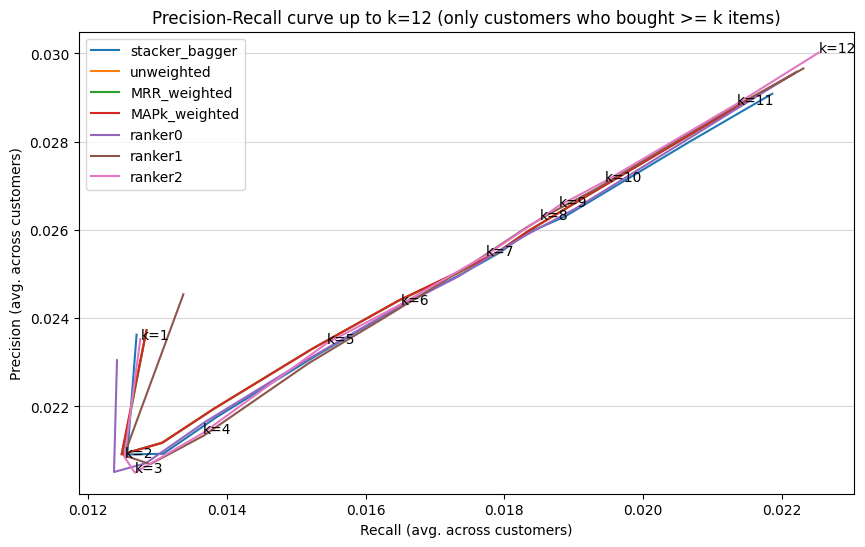

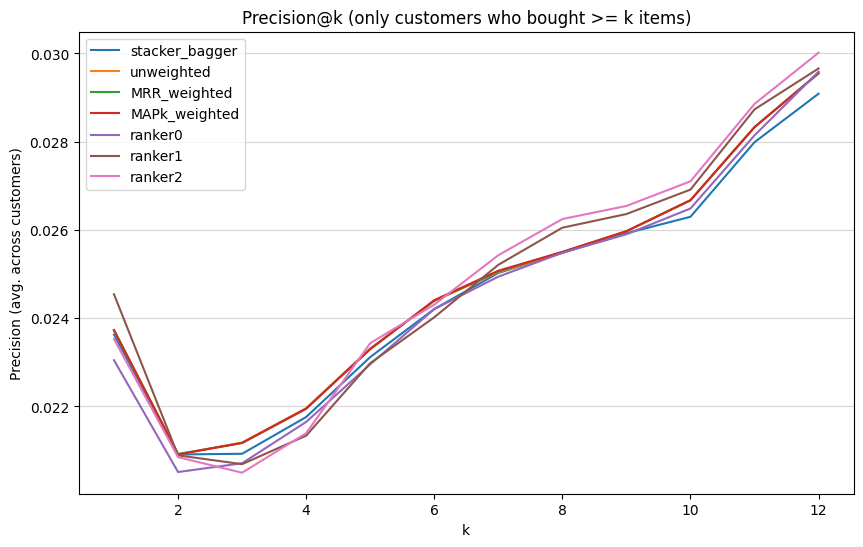

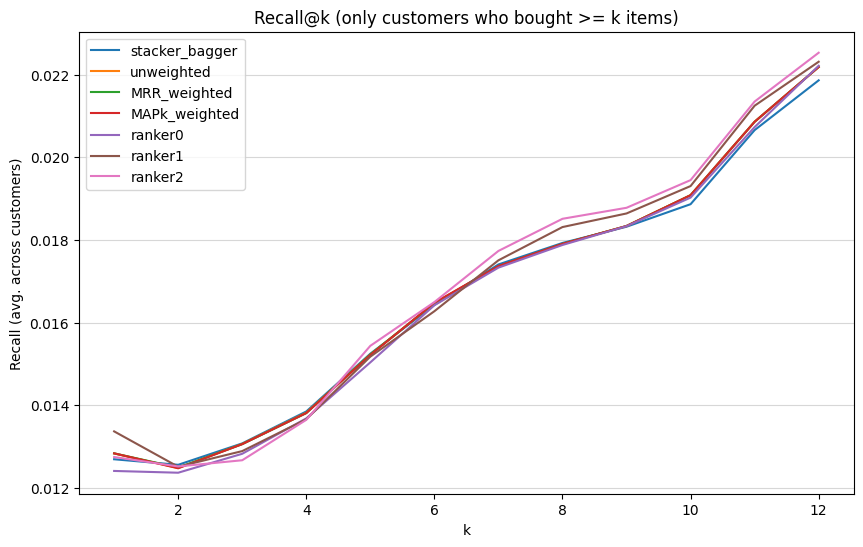

({'stacker_bagger': [0.0011880639659470255,
   0.0010831061677283925,
   0.0010923183201569178,
   0.0011163762105375686,
   0.0011253188821994488,
   0.001133501703134642,
   0.001136699491431339,
   0.001143084015094592,
   0.0011505492088735433,
   0.0011557220935775928,
   0.0011616401200390879],
  'unweighted': [0.0011924372075394684,
   0.001090941558914853,
   0.0011015102260965896,
   0.0011190133157107892,
   0.0011269920520383349,
   0.001133871404021115,
   0.0011363722999075865,
   0.0011446280329942733,
   0.0011530896593290338,
   0.0011585375684812005,
   0.0011641742999792947],
  'MRR_weighted': [0.001193166081138209,
   0.0010913059957142232,
   0.00110177343045169,
   0.0011191499795105528,
   0.0011270576506622215,
   0.0011340220378981882,
   0.0011366150759686271,
   0.0011448710414767422,
   0.0011532597362628636,
   0.0011587059903449095,
   0.0011643413676947231],
  'MAPk_weighted': [0.001193166081138209,
   0.001091123777314538,
   0.0011019556488513754,
   0.0

In [20]:
#getting plots for stacker, also sanity check to ensure data split properly on categories
get_evaluation_plots(test, pred_cols, test_week_transactions, bestsellers_previous_week)

Stacker model doesnt seem to perform better than the individual base rankers. Next test to see the effect of chaning the category that is split on. Idea of next test was that maybe some category splits will improve base rankers abilities, but ran out of time to test, so just compares stackers results when base rankers are trained on data split by different categories.

### Testing with different categories to show stacker works with different categories

In [21]:
#test spliting on different categories to see if different category splits may improve ranker
test['garment_group_split'] = test['stacker_bagger']
categories_to_test = ['product_type_no', 'graphical_appearance_no', 'perceived_colour_value_id', 'department_no']

In [22]:
#training stackers when splitting on different categories (also a sanity check to make sure category is split properly)
for cat in categories_to_test:
    base_rankers = [LGBMRanker(
        objective="lambdarank",
        metric="ndcg",
        boosting_type="dart",
        n_estimators=1,
        importance_type='gain',
        verbose=0
        ) for i in range(nr_rankers)]
    stacker = Stacker(base_rankers, Ranker(AdaBoostClassifier()), use_groups=[True for i in range(nr_rankers)], split_category=cat)
    stacker.fit(train, columns_to_use, nr_validation_weeks=nr_validation_weeks)
    test[cat+"_split"] = stacker.predict(test_X, columns_to_use, weighting="metamodel")

Category 'product_type_no' splits: [array([465, 289,  71, 255, 272, 298, 274, 510,  89, 275,  92,  74,  66,
       285,  59, 155, 521, 308, 503, 268,  93, 492, 512, 264,  75,  79,
       276,  82, 288, 265, 504,  83, 230, 498, 295, 389,  90, 144,  95,
       326,  73, 287], dtype=int32), array([761,  81, 297,  88, 293,  76,  69,  57, 100, 307, 496, 259,  72,
        -1, 300,  78,  77, 296, 156, 489, 262, 299, 302,  91, 468, 515,
        60,  49,  84, 254, 256,  70, 271, 273,  68, 532, 291,  85, 529,
       508, 283], dtype=int32), array([762, 476,  67,  87, 493, 263, 102, 231, 252,  96, 477, 475, 286,
       267, 306, 304, 253, 260, 509, 270,  94, 499, 470,  86, 523, 245,
       495, 494, 261, 161, 491, 257, 305, 258,  98, 525, 277, 511, 467,
       303,  80], dtype=int32)]
computing validation predictions for each of the base rankers...
training metamodel


/home/peter/data_science/Year2/AI Project/Project/ai-project-23-24/PeterKirby/rankers/Stacker.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_no_val[f"train{i}"] = train.groupby(['week', 'customer_id'])[f"ranker{i}"].rank(ascending=False)              #ascending so "best rank" is always the same number (1) - same done when predicting
/home/peter/data_science/Year2/AI Project/Project/ai-project-23-24/PeterKirby/rankers/Stacker.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_no_val[f"tra

metamodel training shape: (5124830, 3)
Computing scores on validatation...
retraining base rankers on full training set...
Predicting with metamodel
Prediction matrix shape: (6658206, 3)
prediction matrix:
[[ 1.   1.   1. ]
 [13.   7.5  4.5]
 [ 7.   7.5  4.5]
 ...
 [11.   7.5  9.5]
 [ 4.   7.5  9.5]
 [ 4.   7.5  9.5]]
Category 'graphical_appearance_no' splits: [array([1010014, 1010001, 1010018, 1010005, 1010021, 1010011, 1010008,
       1010026, 1010029, 1010007], dtype=int32), array([1010004, 1010012, 1010023, 1010002, 1010017, 1010010, 1010003,
       1010024, 1010020, 1010016], dtype=int32), array([1010025, 1010013, 1010019, 1010006, 1010022, 1010027,      -1,
       1010015, 1010009, 1010028], dtype=int32)]
computing validation predictions for each of the base rankers...
training metamodel


/home/peter/data_science/Year2/AI Project/Project/ai-project-23-24/PeterKirby/rankers/Stacker.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_no_val[f"train{i}"] = train.groupby(['week', 'customer_id'])[f"ranker{i}"].rank(ascending=False)              #ascending so "best rank" is always the same number (1) - same done when predicting
/home/peter/data_science/Year2/AI Project/Project/ai-project-23-24/PeterKirby/rankers/Stacker.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_no_val[f"tra

metamodel training shape: (5124830, 3)
Computing scores on validatation...
retraining base rankers on full training set...
Predicting with metamodel
Prediction matrix shape: (6658206, 3)
prediction matrix:
[[ 1.   1.   6. ]
 [ 7.5  2.   3. ]
 [ 7.5  7.  13. ]
 ...
 [ 7.5  7.   8.5]
 [ 7.5  7.  11.5]
 [ 7.5 12.5  4.5]]
Category 'perceived_colour_value_id' splits: [array([1, 7, 3], dtype=int32), array([2, 6, 4], dtype=int32), array([ 5, -1], dtype=int32)]
computing validation predictions for each of the base rankers...
training metamodel


/home/peter/data_science/Year2/AI Project/Project/ai-project-23-24/PeterKirby/rankers/Stacker.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_no_val[f"train{i}"] = train.groupby(['week', 'customer_id'])[f"ranker{i}"].rank(ascending=False)              #ascending so "best rank" is always the same number (1) - same done when predicting
/home/peter/data_science/Year2/AI Project/Project/ai-project-23-24/PeterKirby/rankers/Stacker.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_no_val[f"tra

metamodel training shape: (5124830, 3)
Computing scores on validatation...
retraining base rankers on full training set...
Predicting with metamodel
Prediction matrix shape: (6658206, 3)
prediction matrix:
[[ 1.   1.   2. ]
 [ 7.5 12.   6.5]
 [ 7.5  4.5 12. ]
 ...
 [ 7.5  9.   4. ]
 [ 7.5  9.   6. ]
 [ 7.5 12.   8.5]]
Category 'department_no' splits: [array([5882, 1926, 5672, 2032, 1643, 1339, 8718, 7917, 5962, 1743, 8090,
       5963, 1641, 7658, 4213, 1723, 6280, 8768, 4091, 4222, 4345, 6281,
       7912, 8956, 7530, 3629, 4321, 4221, 1722, 1919, 5658, 1642, 7655,
       3439, 8755, 1212, 7920, 3040, 3509, 6561, 5631, 8812, 4090, 5656,
       7656, 1772, 4344, 7188, 1201, 5783, 1929, 4312, 7921, 7857, 3946,
       1660, 3528, 1222, 5959, 4210, 8748, 2035, 1310, 4215, 3090, 7812,
       3929, 8396, 5952, 1626, 8397, 1670, 1515, 1545, 2080, 4020, 3937,
       5831, 1744, 5252, 8713, 1912, 4212, 8852, 1543, 7814, 6545, 5833,
       1647, 5731, 9986, 1774, 3611, 4342, 4092], dtype=int32)

/home/peter/data_science/Year2/AI Project/Project/ai-project-23-24/PeterKirby/rankers/Stacker.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_no_val[f"train{i}"] = train.groupby(['week', 'customer_id'])[f"ranker{i}"].rank(ascending=False)              #ascending so "best rank" is always the same number (1) - same done when predicting
/home/peter/data_science/Year2/AI Project/Project/ai-project-23-24/PeterKirby/rankers/Stacker.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_no_val[f"tra

metamodel training shape: (5124830, 3)
Computing scores on validatation...
retraining base rankers on full training set...
Predicting with metamodel
Prediction matrix shape: (6658206, 3)
prediction matrix:
[[ 1.   1.   1. ]
 [ 4.5  7.5  7.5]
 [ 4.5  7.5  7.5]
 ...
 [10.   7.5  7.5]
 [10.   7.5  7.5]
 [10.   7.5  7.5]]


In [23]:
#sanity check for train dataset length
len(train.index)

11557594

In [25]:
pred_cols = [c+"_split" for c in categories_to_test] + ["garment_group_split"]

In [26]:
#sanity check that rankings were made for each of the different category splits
test.head()

,t_dat,customer_id,article_id,price,sales_channel_id,week,purchased,bestseller_rank,product_code,prod_name,...,ranker2,stacker_bagger,unweighted,MRR_weighted,MAPk_weighted,garment_group_split,product_type_no_split,graphical_appearance_no_split,perceived_colour_value_id_split,department_no_split
11557594,2020-09-03,28847241659200,925246001,0.128797,2,104,0.0,999.0,925246,25454,...,1.0,6551989.5,6637206.5,6637206.5,6637206.5,6551989.5,6547041.0,6463043.5,6601689.5,6544942.0
11557595,2020-07-14,28847241659200,909370001,0.032947,1,104,0.0,1.0,909370,23319,...,7.5,2272252.0,1944833.5,1944833.5,1944833.5,2272252.0,4219925.0,5081210.5,5632966.0,4863599.0
11557596,2020-07-14,28847241659200,865799006,0.033340,1,104,0.0,2.0,865799,18468,...,7.5,2272252.0,1944833.5,1944833.5,1944833.5,2272252.0,5285328.5,2547908.5,2831284.0,4863599.0
11557597,2020-07-14,28847241659200,918522001,0.041416,1,104,0.0,3.0,918522,26372,...,7.5,5158901.0,5199210.5,5199210.5,5199210.5,5158901.0,3460639.0,4283707.0,6233478.0,4863599.0
11557598,2020-07-14,28847241659200,924243001,0.041549,1,104,0.0,4.0,924243,19190,...,7.5,5158901.0,5199210.5,5199210.5,5199210.5,5158901.0,5285328.5,4283707.0,6233478.0,4863599.0


Evaluation for product_type_no_split
####################



MAP@12 (all customers):             0.001175719529211444
MAP@12 (only purchasing customers): 0.023383156669481566

MRR (all customers):                0.0022296814494222623
MRR (only purchasing customers):    0.04434475175371616



Evaluation for graphical_appearance_no_split
####################

MAP@12 (all customers):             0.0011594020331460845
MAP@12 (only purchasing customers): 0.023058628108485524

MRR (all customers):                0.0021873409927536135
MRR (only purchasing customers):    0.04350266866575007



Evaluation for perceived_colour_value_id_split
####################

MAP@12 (all customers):             0.0008429582500917848
MAP@12 (only purchasing customers): 0.016765073929620292

MRR (all customers):                0.0017210623035051789
MRR (only purchasing customers):    0.034229140948089924



Evaluation for department_no_split
####################

MAP@12 (all customers):             0.001187768212608365
MAP@12 (only purchasing customers): 0.0236227854623

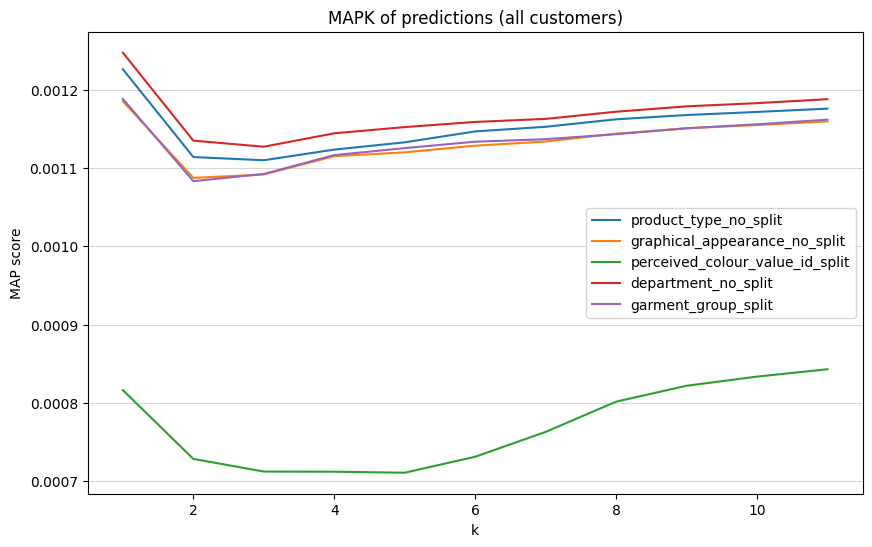

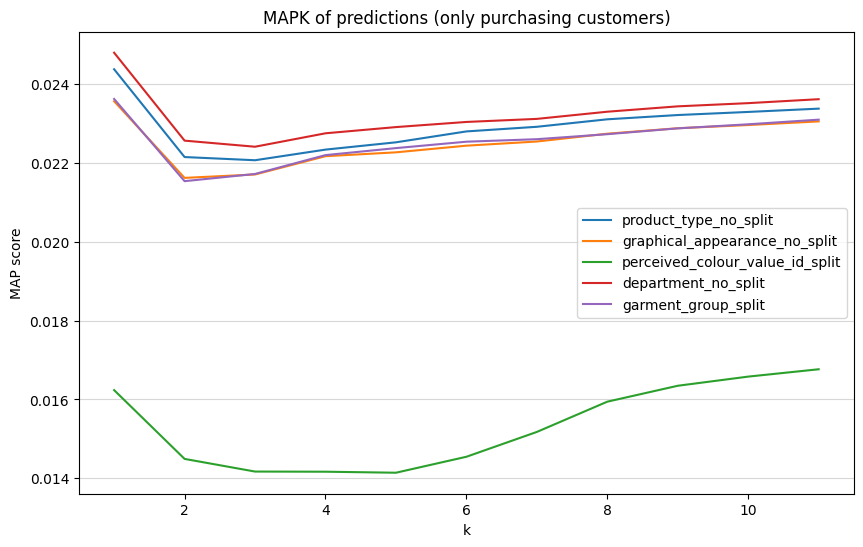

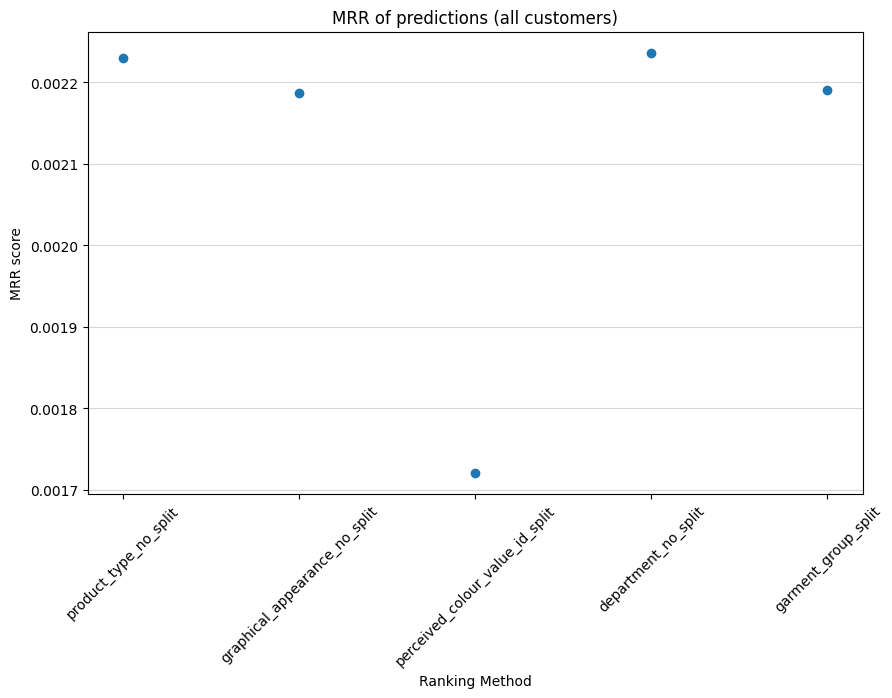

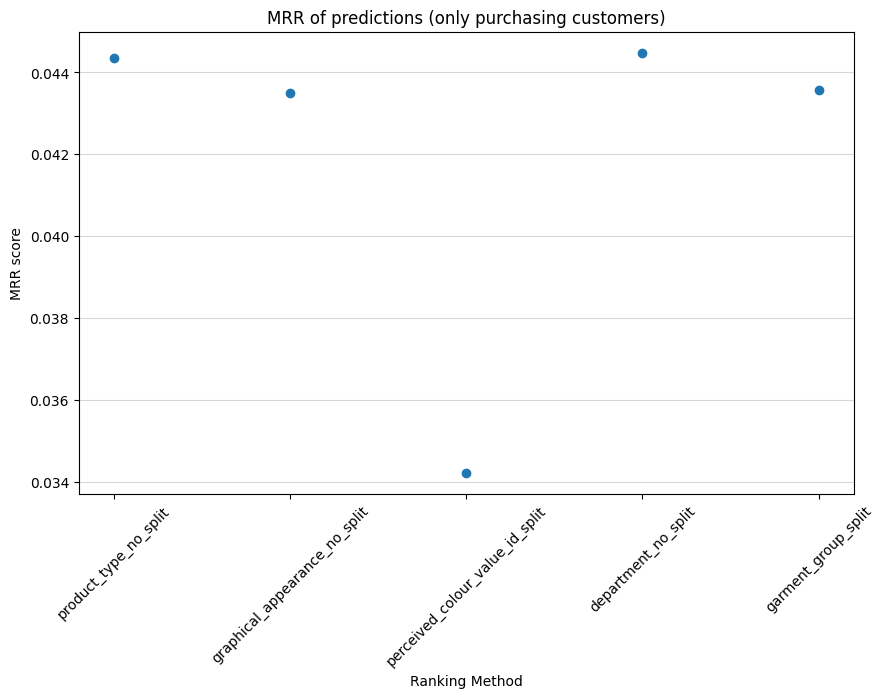

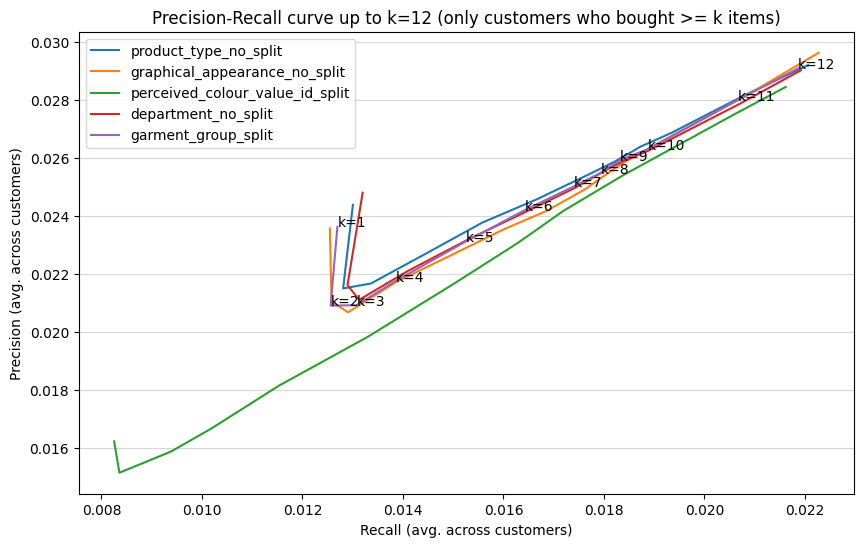

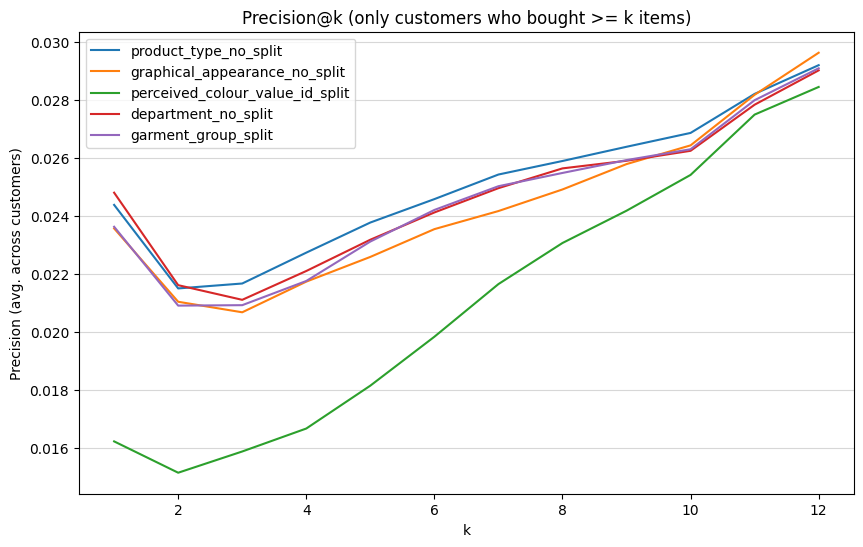

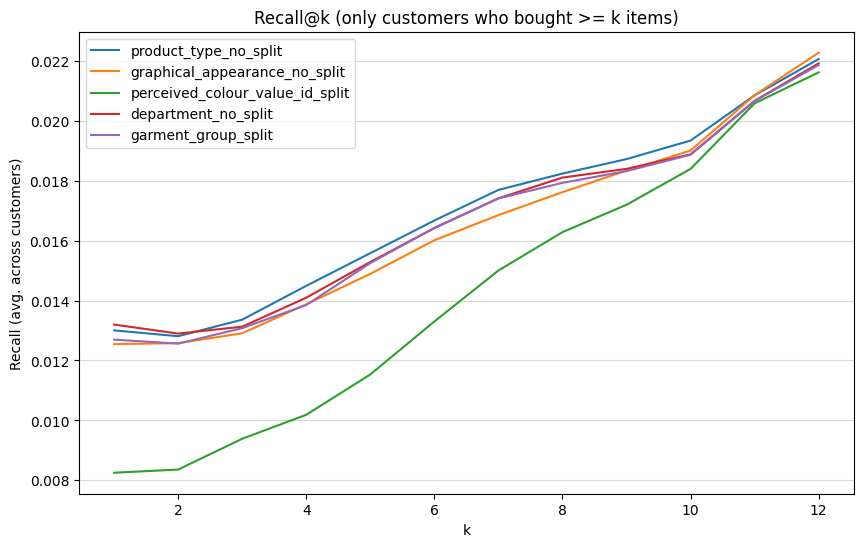

({'product_type_no_split': [0.0012259653930815318,
   0.001113901077275179,
   0.0011098315330155448,
   0.0011234068037920862,
   0.0011327096604906786,
   0.0011466238574906347,
   0.0011525379808429539,
   0.0011620955838226295,
   0.001167542893614451,
   0.0011715029043693854,
   0.001175719529211444],
  'graphical_appearance_no_split': [0.0011851484715520635,
   0.0010872971909211505,
   0.0010916501860247388,
   0.0011149893260510755,
   0.0011199201559465568,
   0.0011284265157736346,
   0.0011337353104285885,
   0.0011437148822584864,
   0.0011506798270763269,
   0.0011547815857493378,
   0.0011594020331460845],
  'perceived_colour_value_id_split': [0.0008163384305893672,
   0.0007285091619411362,
   0.0007123524638357213,
   0.0007121601221916097,
   0.0007108663715538449,
   0.0007312464872341836,
   0.0007629510012822553,
   0.0008015767465555099,
   0.0008218910249926293,
   0.000833580884879985,
   0.0008429582500917848],
  'department_no_split': [0.0012471027274450065,
 

In [27]:
get_evaluation_plots(test, pred_cols, test_week_transactions, bestsellers_previous_week)

Of the tested categories to split on, "department_no" seemed to give the best results.